# Learn from materials data
Training and test data come from the same distributions.

## Get the data and look at distributions of inputs / outputs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import time
import os
from Aux import *
from tensorflow.keras.optimizers import Adam

%run Data_Abaqus_v3/utility_functions

In [50]:
n_inputs = 4
n_outputs = 5

input_names = ['$vf$', '$E_f$ (GPa)', '$b_{m}$ (MPa)', '$c_{m}$']
output_names = ['$b_{eff}$ (MPa)', '$c_{eff}$', '$E_{eff}$ (GPa)', r'$\nu_{eff}$', '$p_{\sigma}$']
a_fixed = 400.
name_ext = '_bis_a[400].pkl'

In [3]:
params_beta_list = [(2., 4.), (3., 2.), (3., 3.), (3., 3.)]
bounds_inputs = np.array([(0.05, 0.4), (200, 600), (300, 500), (0.2, 0.55)])
bounds_outputs = np.array([(300., 800.), (0.16, 0.5), (100., 170.), (0.277, 0.299), (0., 0.8)])
mean_outputs = np.mean(bounds_outputs, axis=-1)
coeff_var_outputs = np.array([0.03, 0.02, 0.005, 0.002, 0.25])
#coeff_var_outputs = np.array([0.02, 0.02, 0.005, 0.005, 0.15])
std_outputs = mean_outputs * coeff_var_outputs

type_norm = '[-1,1]'

cov_aleatoric = np.diag(std_outputs ** 2)
cov_aleatoric_norm = normalize_covariance_from_bounds(cov_aleatoric, bounds_outputs, type_norm=type_norm)
scale_aleatoric_norm = np.sqrt(np.diag(cov_aleatoric_norm))
print(scale_aleatoric_norm)
print(np.mean(np.sqrt(np.diag(cov_aleatoric_norm))))

threshold_pos = normalize_from_bounds(0.01*np.ones((1,5)), bounds_outputs, type_norm=type_norm)[0]
print(threshold_pos)

[0.066      0.03882353 0.01928571 0.05236364 0.25      ]
0.0852945760122231
[ -2.19996     -1.88235294  -3.85685714 -25.27272727  -0.975     ]


### Get the data

In [4]:
#with open('Data_Abaqus_v3/training_random' + name_ext, 'rb') as f:
#    d = pickle.load(f)
#    x_train, y_train = d['inpts'], d['outpts']
#    print('Shape of training data: {}'.format(x_train.shape[0]))
#x_train_norm = normalize_from_bounds(x_train, bounds_inputs, type_norm=type_norm)
#y_train_norm = normalize_from_bounds(y_train, bounds_outputs, type_norm=type_norm)

In [25]:
with open('Data_Abaqus_v3/training_beta' + name_ext, 'rb') as f:
    d = pickle.load(f)
    x_train_beta, y_train_beta = d['inpts'], d['outpts']
    print('Shape of training data: {}'.format(x_train_beta.shape[0]))
x_train_norm_beta = normalize_from_bounds(x_train_beta, bounds_inputs, type_norm=type_norm)
y_train_norm_beta = normalize_from_bounds(y_train_beta, bounds_outputs, type_norm=type_norm)

Shape of training data: 50


In [26]:
with open('Data_Abaqus_v3/testing_random' + name_ext, 'rb') as f:
    d = pickle.load(f)
    x_test, y_test = d['inpts'], d['outpts']
    print('Shape of test data: {}'.format(x_test.shape[0]))
x_test_norm = normalize_from_bounds(x_test, bounds_inputs, type_norm=type_norm)
y_test_norm = normalize_from_bounds(y_test, bounds_outputs, type_norm=type_norm)

Shape of test data: 50


Distribution of inputs


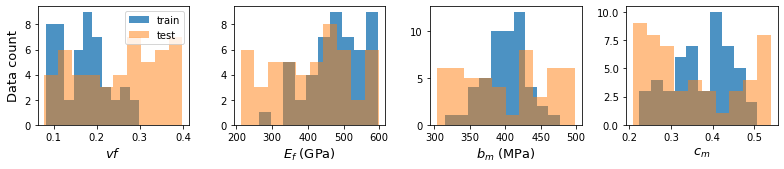

Distribution of outputs


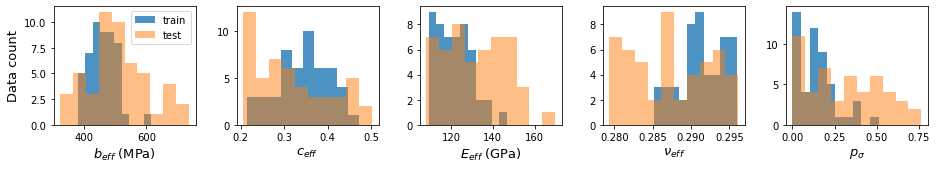

In [65]:
from scipy.stats import gaussian_kde, beta, uniform
print('Distribution of inputs')
fig, ax = plt.subplots(ncols=4, figsize=(11, 2.5))
for i in range(n_inputs):
    xx_ = np.linspace(bounds_inputs[i][0]*0.99, bounds_inputs[i][1]*1.01, 200)
    unif_ = uniform(loc=bounds_inputs[i][0], scale=bounds_inputs[i][1]-bounds_inputs[i][0])
    beta_ = beta(a=params_beta_list[i][0], b=params_beta_list[i][1], loc=bounds_inputs[i][0], 
                 scale=bounds_inputs[i][1]-bounds_inputs[i][0])
    #ax[i].plot(xx_, unif_.pdf(xx_), color='firebrick', alpha=0.5)
    #ax[i].plot(xx_, beta_.pdf(xx_), color='blue', alpha=0.5)
    ax[i].hist(x_train_beta[:, i], alpha=0.8, label='train')
    ax[i].hist(x_test[:, i], alpha=0.5, label='test')
    #ax[i].plot(xx_, gaussian_kde(x_train[:, i]).pdf(xx_), label='train "InD"')
    #ax[i].plot(xx_, gaussian_kde(x_train_beta[:, i]).pdf(xx_), linewidth=2, linestyle='--', label='train')
    #ax[i].plot(xx_, gaussian_kde(x_test[:, i]).pdf(xx_), linewidth=2, label='test')
    ax[i].set_xlabel(input_names[i], fontsize=13)
ax[0].set_ylabel('Data count', fontsize=13)
ax[0].legend()
plt.tight_layout()
fig.savefig('materials_inputs.png', bbox_inches='tight')
plt.show(fig)

print('Distribution of outputs')
fig, ax = plt.subplots(ncols=5, figsize=(13, 2.5))
for i in range(n_outputs):
    xx_ = np.linspace(bounds_outputs[i][0], bounds_outputs[i][1])
    #ax[i].plot(xx_, gaussian_kde(y_train[:, i]).pdf(xx_), label='train "InD"')
    #ax[i].plot(xx_, gaussian_kde(y_train_beta[:, i]).pdf(xx_), label='train')
    #ax[i].plot(xx_, gaussian_kde(y_test[:, i]).pdf(xx_), label='test')
    ax[i].hist(y_train_beta[:, i], alpha=0.8, label='train')
    ax[i].hist(y_test[:, i], alpha=0.5, label='test')
    ax[i].set_xlabel(output_names[i], fontsize=13)
ax[0].set_ylabel('Data count', fontsize=13)
ax[0].legend()
plt.tight_layout()
fig.savefig('materials_outputs.png', bbox_inches='tight')
plt.show(fig)

In [8]:
#data_0 = (x_train_norm, y_train_norm)
#data_red = (x_train_norm[:25], y_train_norm[:25])
data_beta = (x_train_norm_beta, y_train_norm_beta)

## Setup the NN

In [9]:
nn_kwargs = {'n_out': n_outputs,
             'n_in': n_inputs,
             'layers_shape': (20, 20, 20, 20),
             'act': lambda features: tf.nn.leaky_relu(features, alpha=0.01),
             'noise_scale': scale_aleatoric_norm,
             'optimizer': Adam(learning_rate=0.001)}

colors_layers = ['green', 'blue', 'red', 'orange', 'magenta', 'yellow', 'cyan']
markers_layers = ['o', '+', 'x', 'd', 's', 'o', '+']

## Setup the prior

The prior mean is a linear function of volume fraction $y_i = \theta_i \text{v}_f = \theta_i x_1$. It is fitted to the training data.

The prior uncertainty comes from a GP.

In [10]:
from sklearn.feature_selection import f_regression, mutual_info_regression
for j in range(5):
    f_statistic, p_values = f_regression(x_train_norm_beta, y_train_norm_beta[:,j])
    keep = p_values < 0.05
    print(keep)
    mi = mutual_info_regression(x_train_norm_beta, y_train_norm_beta[:,j])
    print(mi)
    print(mi/np.sum(mi)*100)

[ True False  True False]
[0.09615465 0.05728825 0.40609684 0.        ]
[17.18459739 10.2384597  72.57694292  0.        ]
[False False False  True]
[0.03424466 0.         0.15023138 1.46516493]
[ 2.07588574  0.          9.10691381 88.81720045]
[ True False False False]
[1.4370348  0.06592178 0.         0.        ]
[95.61386023  4.38613977  0.          0.        ]
[ True False False False]
[2.06758629 0.         0.         0.        ]
[100.   0.   0.   0.]
[ True False  True  True]
[0.14633167 0.05160948 0.15840993 0.11621967]
[30.96502902 10.92100622 33.52089165 24.59307311]


[[ 0.65577763]
 [-0.19085542]
 [ 0.9333194 ]
 [-0.87567097]
 [ 1.19500706]]
0.0


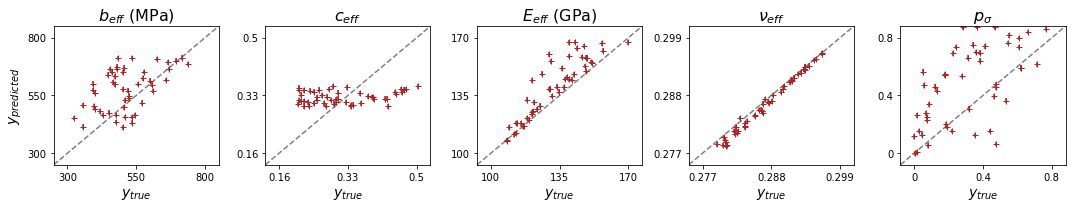

In [78]:
# Prior mean
from sklearn.linear_model import LinearRegression, Lasso
def low_fidelity_model(X):
    model = LinearRegression(fit_intercept=False)
    model.fit(x_train_norm_beta[:,:1], y_train_norm_beta)
    Y = model.predict(X[:,:1])
    print(model.coef_)
    print(model.intercept_)
    return Y

%run Data_Abaqus_v3/utility_functions
y_pred = low_fidelity_model(x_test_norm)
fig, ax = plot_yerr(
    y_test_norm, y_pred, 0.02*np.ones_like(y_pred), 'std', bounds_outputs, output_names, ax_lims=[-1.2, 1.2])
plt.show(fig)

0.44752389334603027
0.4952665020556324
0.3283192474724183
0.09511222546080324
0.6917861615638222


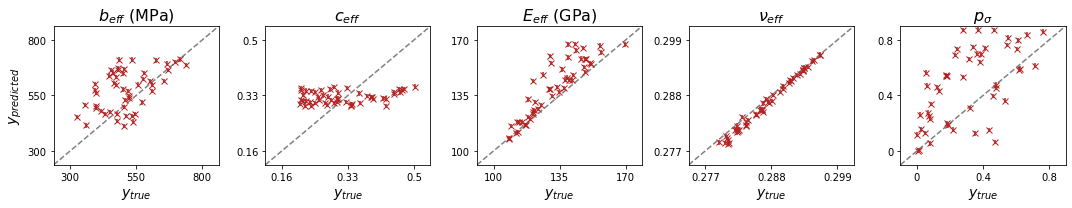

In [79]:
def evaluate_mean(x_values):
    theta_mat = np.array([[0.65577763, -0.19085542, 0.9333194, -0.87567097, 1.19500706],
                              [0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0.],
                              [0., 0., 0., 0., 0.]])
    return np.matmul(x_values, theta_mat)

y_pred = evaluate_mean(x_test_norm)
for j in range(5):
    print(np.sqrt(np.mean((y_test_norm[:,j]-y_pred[:,j])**2)))
fig, ax = plot_yerr(
    y_test_norm, y_pred, 0.02*np.ones_like(y_pred), 'std', bounds_outputs, output_names, ax_lims=[-1.25, 1.25],
    marker='x')
#fig.savefig('materials_prior_mean_preds.png', bbox_inches='tight')
plt.show(fig)

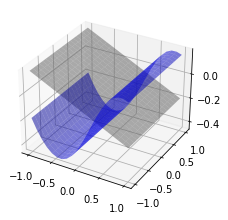

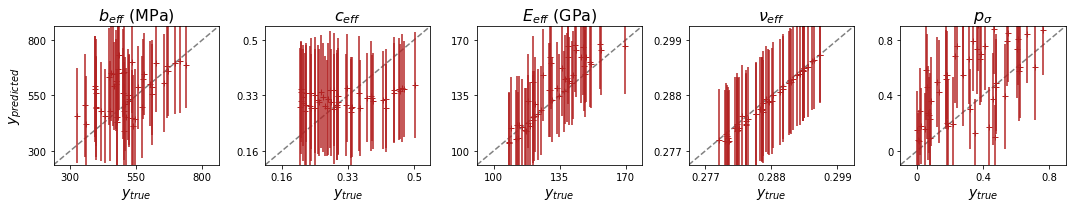

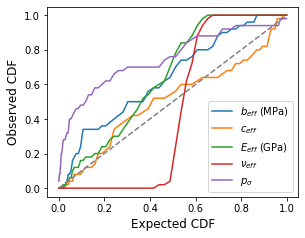

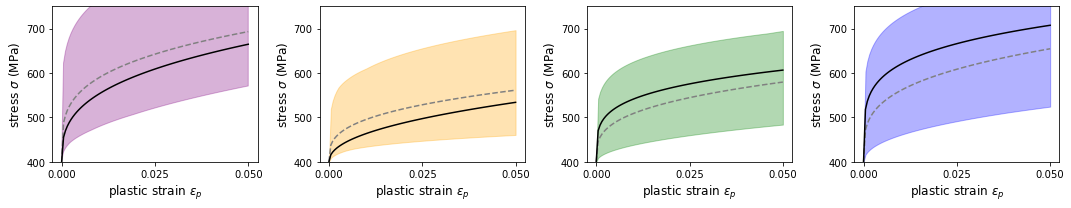

In [86]:
def evaluate_prior(x_values):
    idx = [[0, 1, 2], [0, 2, 3], [0, 1], [0, ], [0, 1, 2, 3]]
    y_prior = evaluate_mean(x_values)
    for j in range(5):
        y_tmp = y_prior[:,j] + sample_from_GP(x_values[:, idx[j]], nout=1, k0=0.2, L=0.8)[:,0]
        y_prior[:,j] = np.maximum(y_tmp, threshold_pos[j])
    return y_prior

#def evaluate_prior(x_values):
#    y_prior = evaluate_mean(x_values) + sample_from_GP(x_values, nout=5, k0=0.2, L=0.8)
#    for j in range(5):
#        y_prior[:,j] = np.maximum(y_prior[:,j], threshold_pos[j])
#    return y_prior

x1, x2 = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
x_values = np.concatenate([x1.reshape((-1,1)), x2.reshape((-1,1)), np.zeros((x2.size, 2))], axis=1)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(15,3))
for _ in range(1):
    y_mean = evaluate_mean(x_values)[:, [1,]]
    ax.plot_surface(x1, x2, y_mean.reshape(x1.shape), alpha=0.5, color='gray')
    y_prior = evaluate_prior(x_values)[:, [1,]]
    ax.plot_surface(x1, x2, y_prior.reshape(x1.shape), alpha=0.5, color='blue')
    #ax[1,i].plot(x_values[:,1], y_prior, color='gray')
fig.tight_layout()
plt.show()

yMC_prior = np.array([evaluate_prior(x_test_norm) for _ in range(100)])
ypred_prior, ystd_prior = np.mean(yMC_prior, axis=0), np.std(yMC_prior, axis=0)
yMC_prior_ = unnormalize_from_bounds(yMC_prior, bounds_outputs, type_norm)

fig, ax = plot_yerr(
    y_test_norm, ypred_prior, ystd_prior, 'std', bounds_outputs, output_names, ax_lims=[-1.25, 1.25])
plt.show(fig)

fig, ax = plt.subplots(figsize=(4.5, 3.5))
for i in range(5):
    xcal, ycal, cal_area = calibration_curve(y_test_norm[...,i], ypred_prior[...,i], ystd_prior[...,i])
    ax.plot(xcal, ycal, label=output_names[i])
ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax.set_xlabel('Expected CDF', fontsize=12)
ax.set_ylabel('Observed CDF', fontsize=12)
ax.legend()
plt.show()

fig, ax = plot_law_MC(a_fixed, y_test, yMC_prior_, indices_test=[16, 5, 6, 7], plot_mean_law=True)
plt.show(fig)

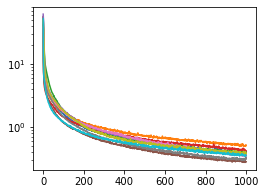

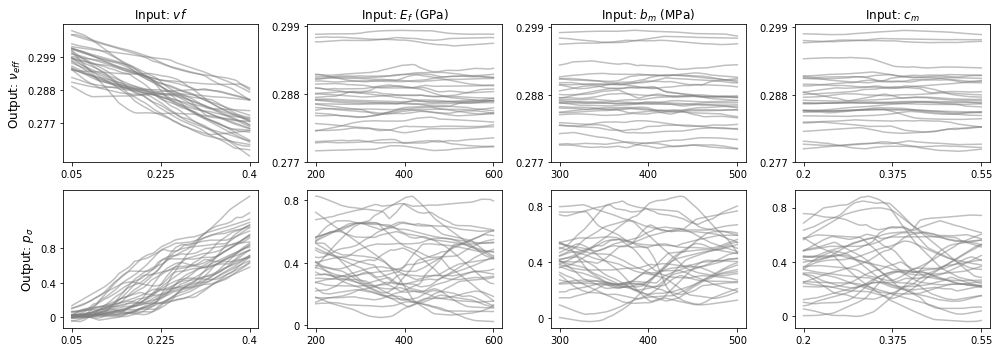

In [114]:
import pickle
with open('priors_081124_N[50]_materials_5outputs.pkl', 'rb') as handle:
    dict_results = pickle.load(handle)
    
tmp_model = create_nn_per_layer(lmda_reg=0., **nn_kwargs)

fig, ax = plt.subplots(figsize=(4, 3))
_, losses = dict_results['prior_0']
for l_ in losses[:10]:
    ax.plot(l_)
ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(14, 5))
ws, losses = dict_results['prior_0']
idx_y = [-2, -1]
for i, w_ in enumerate(ws[:30]):
    tmp_model.set_weights(w_)
    for j in range(4):
        x_test = np.zeros((100, 4))
        x_test[:, j] = np.linspace(-1, 1, 100)
        y_pred = tmp_model.predict(x_test, verbose=False)
        for jj in range(2):
            ax[jj, j].plot(x_test[:, j], y_pred[:,idx_y[jj]], color='gray', alpha=0.5)
            ax[jj, j].set_yticks([-1, 0, 1])
            ax[jj, j].set_xticks([-1, 0, 1])
            bds_i = bounds_outputs[idx_y[jj]]
            ax[jj, j].set_yticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=10)
            bds_i = bounds_inputs[j]
            ax[jj, j].set_xticklabels(['{:.3g}'.format(val) for val in [bds_i[0], (bds_i[0]+bds_i[1])/2, bds_i[1]]], fontsize=10)
            if jj == 0:
                ax[jj, j].set_title('Input: '+input_names[j], fontsize=12)
            if j == 0:
                ax[jj, j].set_ylabel('Output: '+output_names[idx_y[jj]], fontsize=12)
        #set_ax_lims(ax[jj, j], ylabel=(j == 0))
#ax[j].set_title('Prior {}'.format(j))
fig.tight_layout()
#fig.savefig('materials_prior_trends.png', bbox_inches='tight')
plt.show()

## Study with vanilla ensembling

Effect of sample from aleatory?

In [126]:
%run Data_Abaqus_v3/utility_functions
def do_plots(ens_, which_dist='posterior', name=None):
    yMC = ens_.predict(x_test_norm,  which_dist=which_dist)
    ypred, ystd, yperc = np.mean(yMC, axis=0), np.std(yMC, axis=0), np.percentile(yMC, [2.5, 97.5], axis=0)
    yMC_ = unnormalize_from_bounds(yMC, bounds_outputs, type_norm)

    fig, ax = plot_yerr(y_test_norm, ypred, ystd, 'std', bounds_outputs, output_names, ax_lims=[-1.25, 1.25])
    #fig, ax = plot_yerr(y_test_norm, ypred, yperc, 'perc', bounds_outputs, output_names, ax_lims=[-1.05, 1.05])
    if name is not None:
        fig.savefig(name+'_parameters.png', bbox_inches='tight')
    plt.show(fig)
    
    metrics = np.zeros((3, 5))
    fig, ax = plt.subplots(figsize=(4.5, 3.5))
    for i in range(5):
        rmse = np.sqrt(np.mean((y_test_norm[...,i] - ypred[...,i])**2))
        lppd_value = compute_lppd_from_ensemble_preds(y_test[...,i,np.newaxis], yMC_[...,i,np.newaxis], np.sqrt(cov_aleatoric[i,i]))
        xcal, ycal, cal_area = calibration_curve(y_test_norm[...,i], ypred[...,i], ystd[...,i])
        ax.plot(xcal, ycal, label=output_names[i])
        metrics[:, i] = [rmse, cal_area, lppd_value]
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlabel('Expected CDF', fontsize=12)
    ax.set_ylabel('Observed CDF', fontsize=12)
    ax.legend()
    plt.show()
    
    fig, ax = plot_law_MC(a_fixed, y_test, yMC_, indices_test=[16, 5, 6, 7], plot_mean_law=True)
    if name is not None:
        fig.savefig(name+'_laws.png', bbox_inches='tight')
    plt.show(fig)
    
    print(np.around(metrics, 3).T)
    rmse = np.sqrt(np.mean((y_test_norm - ypred)**2))
    lppd_value = compute_lppd_from_ensemble_preds(y_test, yMC_, np.sqrt(np.diag(cov_aleatoric)))
    print('overall rmse={}, cal area={},lppd={}'.format(rmse, np.mean(metrics[1,:]), lppd_value))

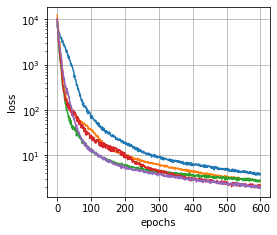

In [17]:
N = 30
vanilla_ens = VanillaEnsemble(n_ens=N, nn_kwargs=nn_kwargs)
vanilla_ens.fit(x=x_train_norm_beta, y=y_train_norm_beta, epochs=600)

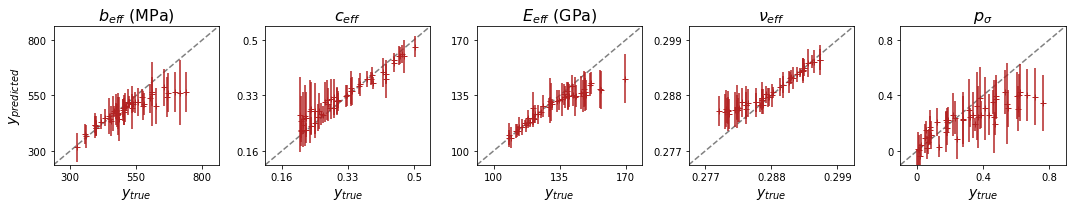

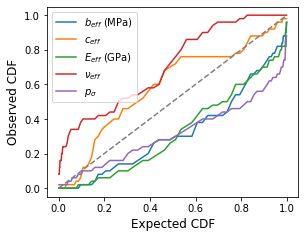

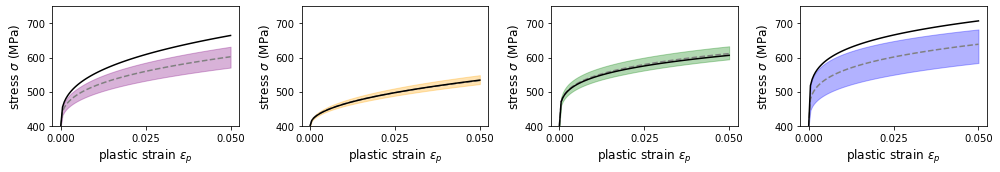

[[ 2.18000e-01  1.76000e-01 -2.77033e+02]
 [ 1.53000e-01  9.60000e-02  1.25553e+02]
 [ 2.05000e-01  1.76000e-01 -3.53817e+02]
 [ 2.00000e-01  2.05000e-01  2.18648e+02]
 [ 3.66000e-01  1.82000e-01  2.67710e+01]]
overall rmse=0.2395562077872033, cal area=0.16714268583169395,lppd=-459.5706256721761


In [127]:
do_plots(vanilla_ens, name='materials_beta_vanilla')

Fitting to data


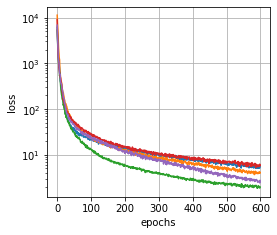

In [19]:
N = 30
ws, _ = dict_results['prior_0']
ws_new = []
for n, ws_ in enumerate(ws[:N]):
    concat_w = np.concatenate([w_.reshape((-1,)) for w_ in ws_], axis=0)
    ws_new.append([concat_w, ])
    
anchored_ens = AnchoredEnsemble(
    n_ens=N, nn_kwargs=nn_kwargs, prior_weights=ws_new, which_reg='degenerate_gaussian')
anchored_ens.fit(x=x_train_norm_beta, y=y_train_norm_beta, epochs=600)

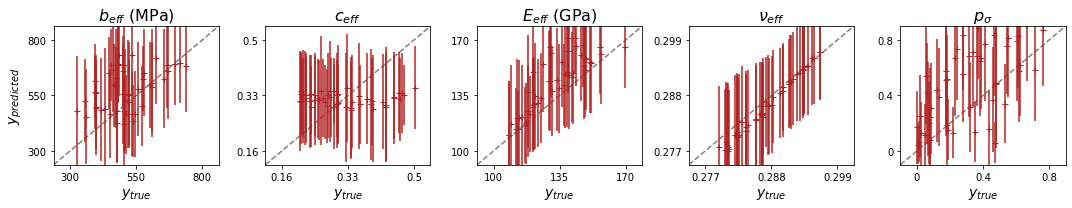

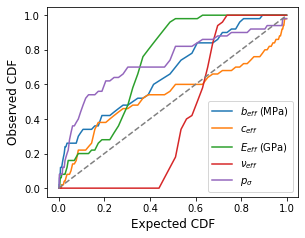

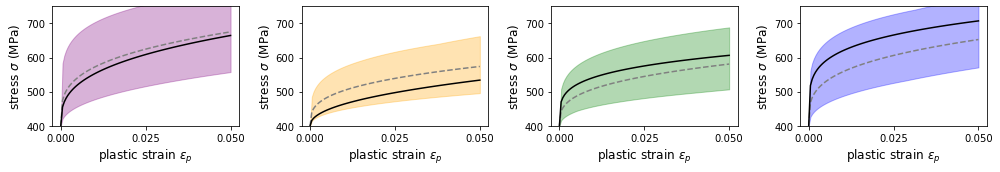

[[ 4.73000e-01  1.67000e-01 -3.39171e+02]
 [ 5.20000e-01  9.50000e-02 -2.13540e+01]
 [ 4.09000e-01  2.25000e-01 -5.17370e+02]
 [ 1.63000e-01  1.96000e-01  1.92467e+02]
 [ 6.79000e-01  2.30000e-01 -5.09800e+00]]
overall rmse=0.47939619998688404, cal area=0.18258548343460082,lppd=-4099.844586932271


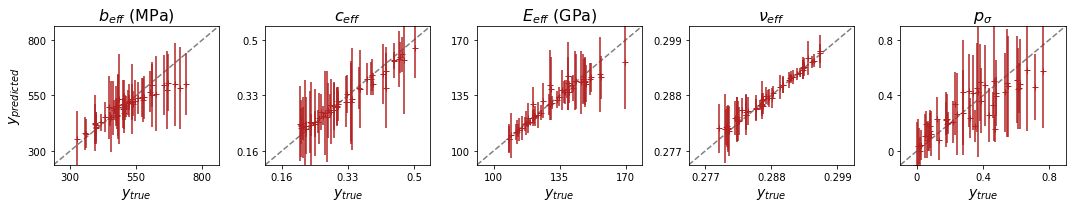

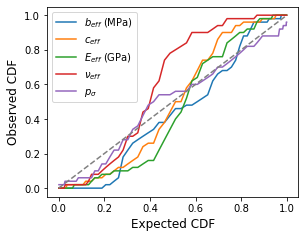

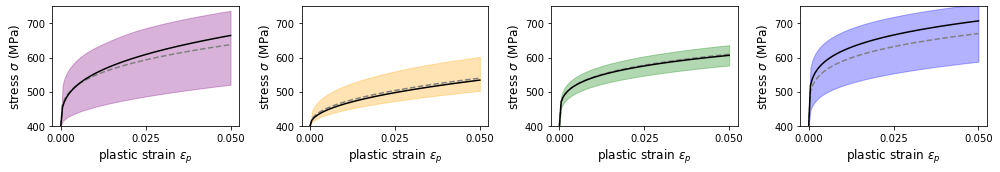

[[ 1.70000e-01  8.30000e-02 -2.49488e+02]
 [ 1.18000e-01  9.80000e-02  1.13242e+02]
 [ 1.26000e-01  1.09000e-01 -1.27730e+02]
 [ 6.90000e-02  1.42000e-01  2.79866e+02]
 [ 2.66000e-01  3.50000e-02  3.56320e+01]]
overall rmse=0.1639322428481859, cal area=0.09322582028679263,lppd=-114.21129636043179


In [128]:
do_plots(anchored_ens, 'prior')
do_plots(anchored_ens, 'posterior', name='materials_beta_anchored')

In [133]:
vanilla_results = np.array([[ 2.18000e-01,  1.76000e-01, -2.77033e+02],
 [ 1.53000e-01,  9.60000e-02,  1.25553e+02],
 [ 2.05000e-01,  1.76000e-01, -3.53817e+02],
 [ 2.00000e-01 , 2.05000e-01 , 2.18648e+02],
 [ 3.66000e-01 , 1.82000e-01,  2.67710e+01]])
anchored_results = np.array([[ 1.70000e-01,  8.30000e-02, -2.49488e+02],
 [ 1.18000e-01,  9.80000e-02,  1.13242e+02],
 [ 1.26000e-01,  1.09000e-01, -1.27730e+02],
 [ 6.90000e-02,  1.42000e-01,  2.79866e+02],
 [ 2.66000e-01,  3.50000e-02,  3.56320e+01]])
print((vanilla_results-anchored_results)/np.abs(vanilla_results))

[[ 0.22018349  0.52840909 -0.09942859]
 [ 0.22875817 -0.02083333  0.09805421]
 [ 0.38536585  0.38068182 -0.63899417]
 [ 0.655       0.30731707 -0.27998427]
 [ 0.27322404  0.80769231 -0.33099249]]


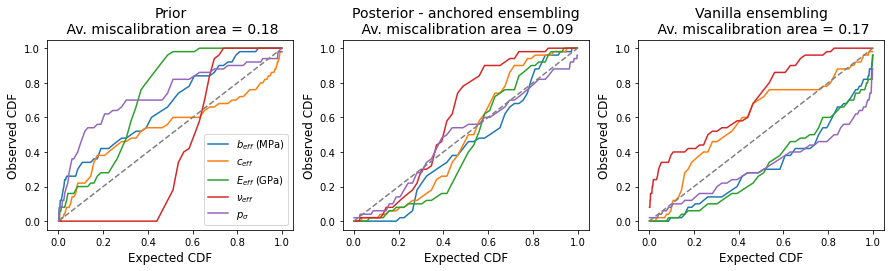

In [121]:
fig, ax = plt.subplots(figsize=(15, 3.5), ncols=3)
for j, title in enumerate(['Prior', 'Posterior - anchored ensembling', 'Vanilla ensembling']):
    if j == 0:
        yMC = anchored_ens.predict(x_test_norm,  which_dist='prior')
    elif j == 1:
        yMC = anchored_ens.predict(x_test_norm,  which_dist='posterior')
    elif j == 2:
        yMC = vanilla_ens.predict(x_test_norm,  which_dist='posterior')
    ypred, ystd = np.mean(yMC, axis=0), np.std(yMC, axis=0)
    
    av_cal_area = 0.
    for i in range(5):
        xcal, ycal, cal_area = calibration_curve(y_test_norm[...,i], ypred[...,i], ystd[...,i])
        ax[j].plot(xcal, ycal, label=output_names[i])
        av_cal_area += cal_area / 5.
    ax[j].plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax[j].set_xlabel('Expected CDF', fontsize=12)
    ax[j].set_ylabel('Observed CDF', fontsize=12)
    ax[j].set_title(title+'\n Av. miscalibration area = {:.2f}'.format(av_cal_area), fontsize=14)
ax[0].legend()
#fig.tight_layout()
#fig.savefig('materials_calibration_curves.png', bbox_inches='tight')
plt.show()

## In distribution data

In [21]:
with open('Data_Abaqus_v3/training_random' + name_ext, 'rb') as f:
    d = pickle.load(f)
    x_train, y_train = d['inpts'], d['outpts']
    print('Shape of training data: {}'.format(x_train.shape[0]))
x_train_norm = normalize_from_bounds(x_train, bounds_inputs, type_norm=type_norm)
y_train_norm = normalize_from_bounds(y_train, bounds_outputs, type_norm=type_norm)

Shape of training data: 100


Fitting to data


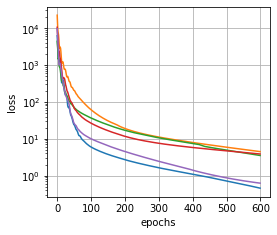

Fitting to data


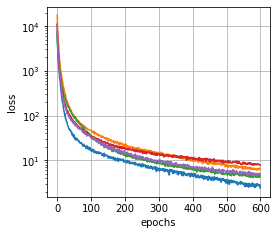

Fitting to data


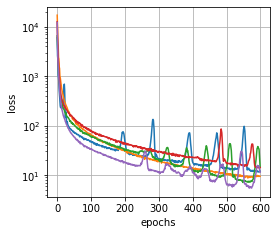

In [22]:
N = 30
ws, _ = dict_results['prior_0']
ws_new = []
for n, ws_ in enumerate(ws[:N]):
    concat_w = np.concatenate([w_.reshape((-1,)) for w_ in ws_], axis=0)
    ws_new.append([concat_w, ])
    
anchored_ens_25 = AnchoredEnsemble(
    n_ens=N, nn_kwargs=nn_kwargs, prior_weights=ws_new, which_reg='degenerate_gaussian')
anchored_ens_25.fit(x=x_train_norm[:25], y=y_train_norm[:25], epochs=600)

anchored_ens_50 = AnchoredEnsemble(
    n_ens=N, nn_kwargs=nn_kwargs, prior_weights=ws_new, which_reg='degenerate_gaussian')
anchored_ens_50.fit(x=x_train_norm[:50], y=y_train_norm[:50], epochs=600)

anchored_ens_100 = AnchoredEnsemble(
    n_ens=N, nn_kwargs=nn_kwargs, prior_weights=ws_new, which_reg='degenerate_gaussian')
anchored_ens_100.fit(x=x_train_norm, y=y_train_norm, epochs=600)

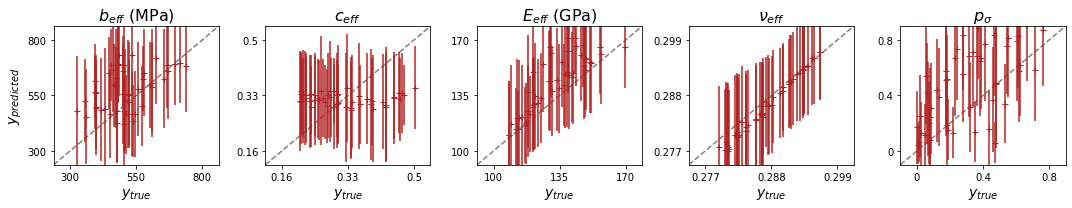

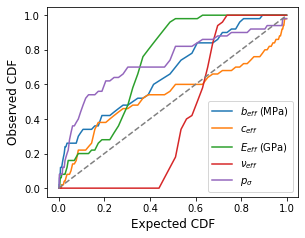

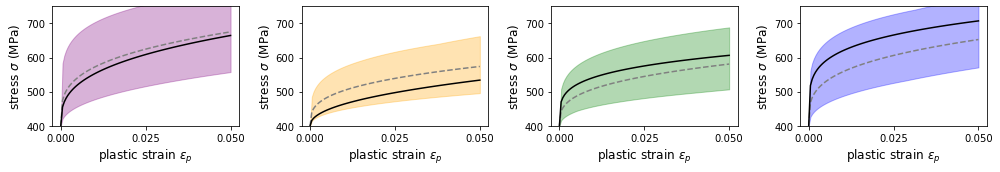

[[ 4.73000e-01  1.67000e-01 -3.39171e+02]
 [ 5.20000e-01  9.50000e-02 -2.13540e+01]
 [ 4.09000e-01  2.25000e-01 -5.17370e+02]
 [ 1.63000e-01  1.96000e-01  1.92467e+02]
 [ 6.79000e-01  2.30000e-01 -5.09800e+00]]
overall rmse=0.47939619998688404, cal area=0.18258548343460082,lppd=-4099.844586932271


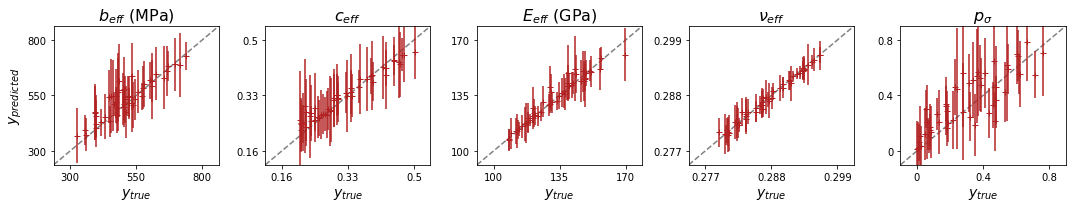

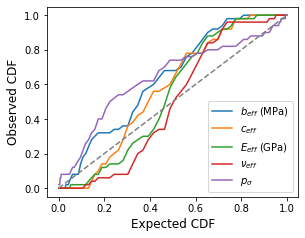

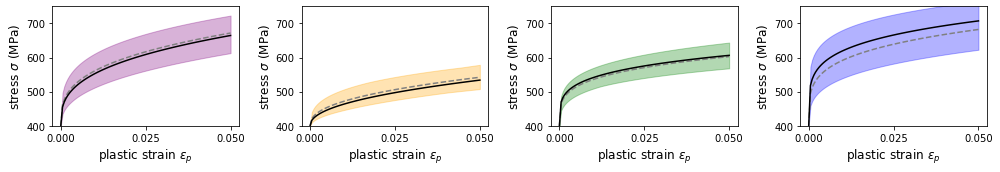

[[ 1.97000e-01  1.39000e-01 -2.59005e+02]
 [ 1.53000e-01  1.11000e-01  1.03193e+02]
 [ 1.01000e-01  1.10000e-01 -1.27551e+02]
 [ 5.10000e-02  1.12000e-01  2.82305e+02]
 [ 3.25000e-01  1.43000e-01  3.20660e+01]]
overall rmse=0.1901731450101691, cal area=0.12319174916273493,lppd=-195.85070620891065


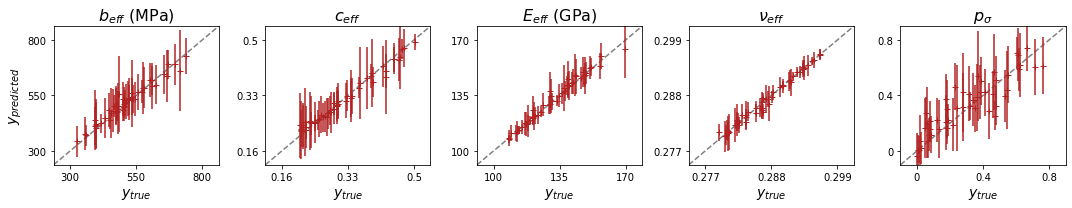

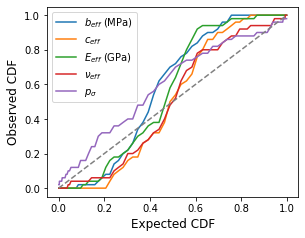

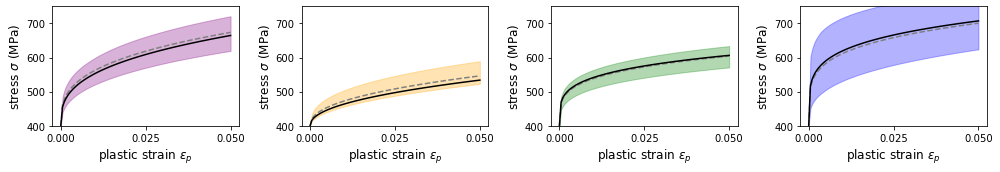

[[ 9.00000e-02  1.37000e-01 -2.37638e+02]
 [ 8.20000e-02  1.20000e-01  1.30144e+02]
 [ 6.70000e-02  1.24000e-01 -1.11215e+02]
 [ 5.50000e-02  9.10000e-02  2.88822e+02]
 [ 2.54000e-01  9.80000e-02  4.03260e+01]]
overall rmse=0.13176335154162003, cal area=0.114081409857734,lppd=33.49074467326136


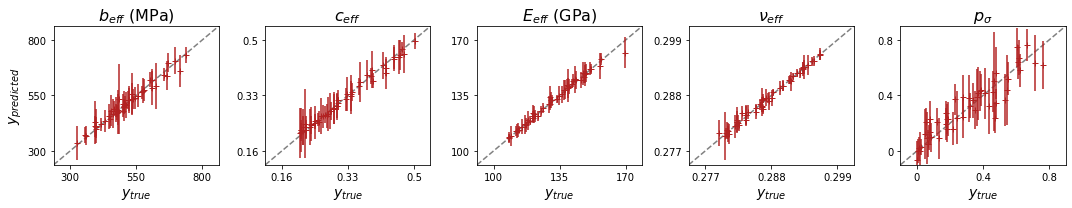

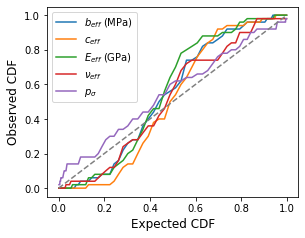

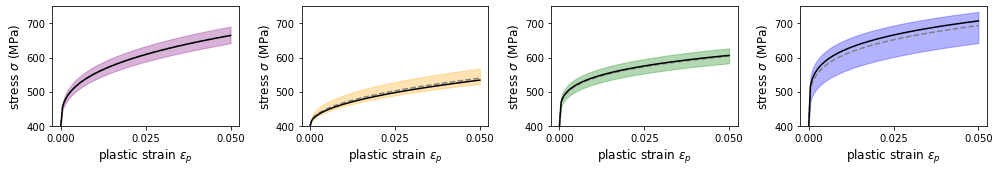

[[ 6.90000e-02  9.30000e-02 -2.22907e+02]
 [ 6.00000e-02  1.14000e-01  1.47460e+02]
 [ 4.80000e-02  1.18000e-01 -9.69270e+01]
 [ 4.80000e-02  7.20000e-02  2.95238e+02]
 [ 2.05000e-01  5.50000e-02  4.78340e+01]]
overall rmse=0.10479742527171616, cal area=0.0902582990154897,lppd=155.2007556770532


In [129]:
do_plots(anchored_ens_50, 'prior', name='materials_unif_prior')
do_plots(anchored_ens_25, 'posterior')
do_plots(anchored_ens_50, 'posterior', name='materials_unif_50')
do_plots(anchored_ens_100, 'posterior', name='materials_unif_100')
    
